Base image shape: (323, 286, 3)
Overlay image shape: (417, 288, 3)
Selected Points: [(161, 65), (234, 54), (160, 188), (233, 190)]
Homography matrix:
 [[ 1.75822424e-01 -2.90039871e-03  1.61000000e+02]
 [-5.61136287e-02  2.94373806e-01  6.50000000e+01]
 [-3.31836746e-04 -3.13948237e-06  1.00000000e+00]]


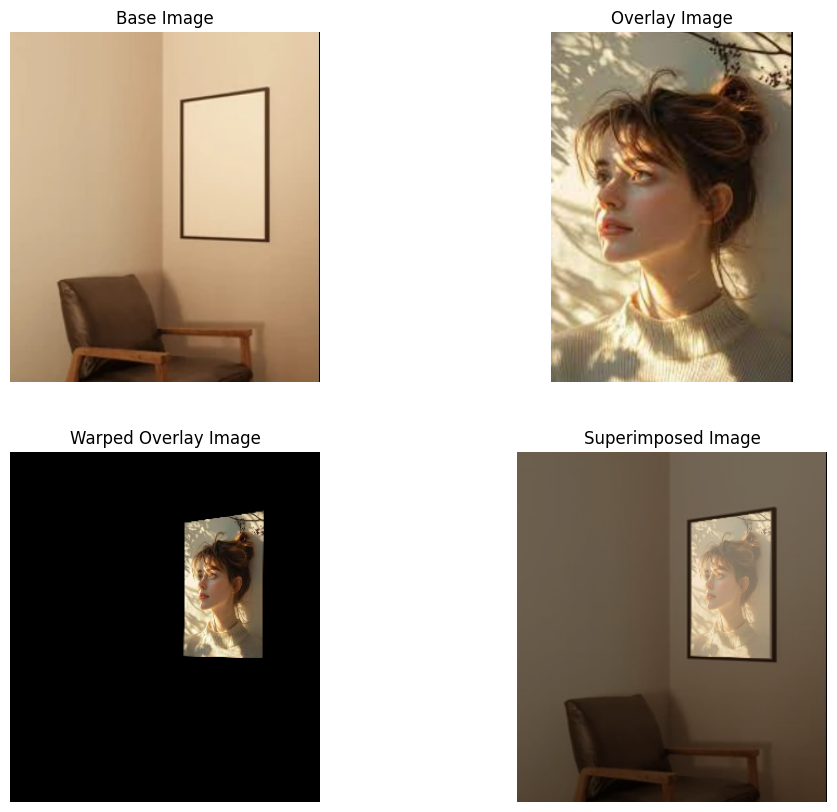

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Initialize a list to store the selected points
selected_points = []

# Callback function for mouse click events
def mouse_click(event, x, y, flags, param):
    global selected_points

    if event == cv2.EVENT_LBUTTONDOWN:
        selected_points.append((x, y))
        # Draw a circle temporarily on the copy image for visual feedback
        cv2.circle(base_image_copy, (x, y), 4, (0, 0, 255), -1)
        cv2.imshow('Base Image', base_image_copy)

# Load the base image and the image to be superimposed
base_image_path = 'ibb1.jpg' 
overlay_image_path = 'ibb2.jpg' 

# Attempt to load the images
base_image = cv2.imread(base_image_path)
overlay_image = cv2.imread(overlay_image_path)

# Check if the images were loaded successfully
if base_image is None:
    raise FileNotFoundError(f"Base image '{base_image_path}' not found or could not be loaded.")
if overlay_image is None:
    raise FileNotFoundError(f"Overlay image '{overlay_image_path}' not found or could not be loaded.")

# Convert images to float32 and normalize
base_image = base_image.astype(np.float32) / np.iinfo(base_image.dtype).max
overlay_image = overlay_image.astype(np.float32) / np.iinfo(overlay_image.dtype).max

# Make a copy of the base image to show points 
base_image_copy = base_image.copy()

# Print the shapes of both images
print("Base image shape:", base_image.shape)
print("Overlay image shape:", overlay_image.shape)

# Display the base image and set the mouse callback to select points
cv2.imshow('Base Image', base_image_copy)
cv2.setMouseCallback('Base Image', mouse_click)

# Wait for the user to select four points
while len(selected_points) < 4:
    cv2.waitKey(1)

# Close all OpenCV windows
cv2.destroyAllWindows()

# Print the selected points
print("Selected Points:", selected_points)

# Prepare the source (overlay image) and destination (selected) points for perspective transformation
dst_points = np.array(selected_points).astype(np.float32)
h_overlay, w_overlay = overlay_image.shape[:2]
src_points = np.float32([[0, 0], [w_overlay, 0], [0, h_overlay], [w_overlay, h_overlay]])

# Compute the homography matrix
H = cv2.getPerspectiveTransform(src_points, dst_points)
print('Homography matrix:\n', H)

# Warp the overlay image using the homography matrix to fit the base image
warped_overlay_image = cv2.warpPerspective(overlay_image, H, (base_image.shape[1], base_image.shape[0]))

# Combine the base image and the warped overlay image
superimposed_image = cv2.addWeighted(base_image, 0.5, warped_overlay_image,0.5, 0)
# Create a figure with a specified size
plt.figure(figsize=(12, 10))  # Adjust the size as needed (width, height)
# Display the images
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB))
plt.title('Base Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.title('Overlay Image')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(warped_overlay_image , cv2.COLOR_BGR2RGB))
plt.title('Warped Overlay Image')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(superimposed_image, cv2.COLOR_BGR2RGB))
plt.title('Superimposed Image')
plt.axis('off')

plt.show()


In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def findFeatures(img):
    sift = cv.SIFT_create()
    key, des = sift.detectAndCompute(img, None)
    return key, des

def findMatches(des1, des5):
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des5, k=2)
    return matches


def calHomography(sample):
    A = []
    for i in range(len(sample)):
        x1, y1, x2, y2 = sample[i, 0], sample[i, 1], sample[i, 2], sample[i, 3]
        A.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])

    A = np.matrix(A)
    U, S, V = np.linalg.svd(A)
    H = np.reshape(V[-1], (3, 3))
    H = (1/H.item(8))*H
    return H

def calDistance(H, correspondence):
    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(H, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)


def RANSAC(corres,threshold):
    max_inliers = []
    homography = []

    for i in range(int(np.log(1 - 0.95)/np.log(1 - (1 - 0.5)**4))):
        corr1 = corres[np.random.randint(0, len(corres))]
        corr2 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((corr1, corr2))
        corr3 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((sample, corr3))
        corr4 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((sample, corr4))
        
        
        h = calHomography(sample)
        inliers = []
        
        for j in range(len(corres)):
            distance = calDistance(h, corres[j])
            if distance < threshold:
                inliers.append(corres[j])
        

        if len(inliers) > len(max_inliers):
            max_inliers = inliers
            
            homography = h
        
    return homography,inliers

img1 = cv.imread('img1.ppm')
img5 = cv.imread('img5.ppm')

estimated_threshold = 100

correspondence = []
key1, des1 = findFeatures(img1)
key5, des5 = findFeatures(img5)
keypoints = [key1, key5]
matches = findMatches(des1, des5)

for match in matches:
    (x1, y1) = keypoints[0][match[0].queryIdx].pt
    (x2, y2) = keypoints[1][match[0].trainIdx].pt
    correspondence.append([x1, y1, x2, y2])

corres = np.matrix(correspondence)
H,inliers =RANSAC(corres,estimated_threshold)
print(H)

print('no of inliers',len(inliers))

[[ 1.41134525e+00 -1.47750239e+00  4.06449017e+02]
 [ 9.41149672e-01 -1.00039985e+00  2.83684743e+02]
 [ 3.34927884e-03 -3.55848470e-03  1.00000000e+00]]
no of inliers 191
